# Model: XGBoost

### Importing Libraries

In [1]:
import _pickle as pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

### Loading in Data

In [2]:
with open("top10_df.pkl",'rb') as fp:
    df = pickle.load(fp)

### Scaling the Data

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

features_df = df.drop(["Decision"], 1)

scaled_df = pd.DataFrame(scaler.fit_transform(features_df), 
                               index=features_df.index, 
                               columns=features_df.columns)

df = scaled_df.join(df.Decision)

### Splitting the Data

In [4]:
X = df.drop(["Decision"], 1)
y = df.Decision

# Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Helper Functions

#### Function for plotting confusion matrix

In [5]:
def plot_confusion_matrix(y_true, y_pred, labels=["Sell", "Buy", "Hold"], 
                          normalize=False, title=None, cmap=plt.cm.coolwarm):

    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='ACTUAL',
           xlabel='PREDICTED')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="snow" if cm[i, j] > thresh else "orange",
                    size=26)
    ax.grid(False)
    fig.tight_layout()
    return ax

## Modeling
The preferred evaluation metric used will be __Precision__ for each class.  They will be optimized using the __F1 Score-Macro-Average__ to balance the Precision and Recall.  This is done because we want to not only be correct when predicting but also make a decent amount of predictions for each class.  Classes such as 'Buy' and 'Sell' are more important than 'Hold'.

### Fitting and Training

In [6]:
# Preventing error from occuring: XGBoost causes kernel to die.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
import xgboost as xgb

In [7]:
# Instatiating the model classifier
clf = xgb.XGBClassifier()

# Fitting to the Data
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

### Printing out Evaluation Metrics

In [8]:
# Classifier predictions
pred = clf.predict(X_test)

#Printing out results
report = classification_report(y_test, pred, target_names=['Sell', 'Buy', 'Hold'])
print(report)

              precision    recall  f1-score   support

        Sell       0.39      0.02      0.04      2895
         Buy       0.48      0.33      0.39      5571
        Hold       0.46      0.76      0.57      6577

   micro avg       0.46      0.46      0.46     15043
   macro avg       0.44      0.37      0.33     15043
weighted avg       0.45      0.46      0.40     15043



### Confusion Matrix

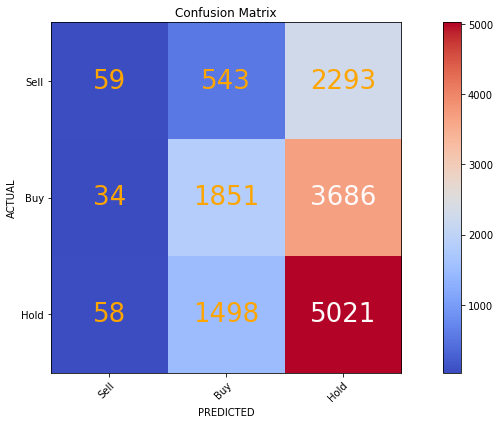

In [9]:
plot_confusion_matrix(y_test, pred, title="Confusion Matrix")
np.set_printoptions(precision=1)
# Plot non-normalized confusion matrix
plt.show()

## Tuning Model Parameters

In [10]:
from sklearn.model_selection import GridSearchCV

### Parameters

In [12]:
# Parameters to tune
params = {"booster": ["gbtree", "gblinear", 'dart'],
          "eta": [.1, .3, .6, .9],
          "gamma": [0, 1, 10],
          "n_estimators": [50, 100, 200],
          "max_depth": [1, 3, 6],
          "grow_policy": ['depthwise', 'lossguide']}

In [13]:
search = GridSearchCV(clf, params, cv=3, return_train_score=True, verbose=5, scoring='f1_macro')

search.fit(X,y)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.3166858865339485, total=   3.5s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.3125052693388186, total=   3.4s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.1s remaining:    0.0s


[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.315013231146291, total=   3.5s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.8s remaining:    0.0s


[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100, score=0.32761369370052473, total=   6.6s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   17.6s remaining:    0.0s


[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100, score=0.3239326862400621, total=   7.3s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100, score=0.32072276420973816, total=   7.8s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=200 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=200, score=0.33272855001580154, total=  15.6s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=200 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=200, score=0.32992973113700313, total=  16.7s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=200 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=

[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=100, score=0.3387046754777652, total=  14.9s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=200 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=200, score=0.3494219622675347, total=  28.4s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=200 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=200, score=0.3443700823591142, total=  26.8s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=200 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=200, score=0.34589336589991, total=  26.7s
[CV] booster=gbtree, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=50, sc

[CV]  booster=gbtree, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=200, score=0.3615112316006068, total=  54.2s
[CV] booster=gbtree, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=200 
[CV]  booster=gbtree, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=200, score=0.35404033568154175, total=  54.1s
[CV] booster=gbtree, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=200 
[CV]  booster=gbtree, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=200, score=0.3525588139692954, total=  55.2s
[CV] booster=gbtree, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=50, score=0.3166858865339485, total=   3.5s
[CV] booster=gbtree, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=50, s

[CV]  booster=gbtree, eta=0.1, gamma=10, grow_policy=depthwise, max_depth=1, n_estimators=200, score=0.31854257022775895, total=  16.6s
[CV] booster=gbtree, eta=0.1, gamma=10, grow_policy=depthwise, max_depth=1, n_estimators=200 
[CV]  booster=gbtree, eta=0.1, gamma=10, grow_policy=depthwise, max_depth=1, n_estimators=200, score=0.3177510275706368, total=  17.0s
[CV] booster=gbtree, eta=0.1, gamma=10, grow_policy=depthwise, max_depth=3, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=10, grow_policy=depthwise, max_depth=3, n_estimators=50, score=0.319706570604716, total=   9.8s
[CV] booster=gbtree, eta=0.1, gamma=10, grow_policy=depthwise, max_depth=3, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=10, grow_policy=depthwise, max_depth=3, n_estimators=50, score=0.3168999535958392, total=   9.0s
[CV] booster=gbtree, eta=0.1, gamma=10, grow_policy=depthwise, max_depth=3, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=10, grow_policy=depthwise, max_depth=3, n_estimators

[CV]  booster=gbtree, eta=0.1, gamma=10, grow_policy=lossguide, max_depth=3, n_estimators=200, score=0.31568228594699826, total=  35.9s
[CV] booster=gbtree, eta=0.1, gamma=10, grow_policy=lossguide, max_depth=3, n_estimators=200 
[CV]  booster=gbtree, eta=0.1, gamma=10, grow_policy=lossguide, max_depth=3, n_estimators=200, score=0.3200568197439018, total=  35.0s
[CV] booster=gbtree, eta=0.1, gamma=10, grow_policy=lossguide, max_depth=6, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=10, grow_policy=lossguide, max_depth=6, n_estimators=50, score=0.31904319523682184, total=  17.8s
[CV] booster=gbtree, eta=0.1, gamma=10, grow_policy=lossguide, max_depth=6, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=10, grow_policy=lossguide, max_depth=6, n_estimators=50, score=0.31869024439330196, total=  17.9s
[CV] booster=gbtree, eta=0.1, gamma=10, grow_policy=lossguide, max_depth=6, n_estimators=50 
[CV]  booster=gbtree, eta=0.1, gamma=10, grow_policy=lossguide, max_depth=6, n_estimat

[CV]  booster=gbtree, eta=0.3, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=200, score=0.3531399464809586, total=  50.6s
[CV] booster=gbtree, eta=0.3, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=50 
[CV]  booster=gbtree, eta=0.3, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=50, score=0.3166858865339485, total=   3.3s
[CV] booster=gbtree, eta=0.3, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=50 
[CV]  booster=gbtree, eta=0.3, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=50, score=0.3125052693388186, total=   4.2s
[CV] booster=gbtree, eta=0.3, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=50 
[CV]  booster=gbtree, eta=0.3, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=50, score=0.315013231146291, total=   3.8s
[CV] booster=gbtree, eta=0.3, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=100 
[CV]  booster=gbtree, eta=0.3, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=100, score

[CV]  booster=gbtree, eta=0.3, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=50, score=0.3300615427151856, total=   6.8s
[CV] booster=gbtree, eta=0.3, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=50 
[CV]  booster=gbtree, eta=0.3, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=50, score=0.3290296414284524, total=   6.9s
[CV] booster=gbtree, eta=0.3, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=50 
[CV]  booster=gbtree, eta=0.3, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=50, score=0.3273878765856798, total=   6.9s
[CV] booster=gbtree, eta=0.3, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=100 
[CV]  booster=gbtree, eta=0.3, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=100, score=0.3409660078443979, total=  13.5s
[CV] booster=gbtree, eta=0.3, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=100 
[CV]  booster=gbtree, eta=0.3, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=100, sco

[CV]  booster=gbtree, eta=0.3, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=50, score=0.34216058676316924, total=  15.4s
[CV] booster=gbtree, eta=0.3, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=50 
[CV]  booster=gbtree, eta=0.3, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=50, score=0.34413661614218943, total=  15.6s
[CV] booster=gbtree, eta=0.3, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=100 
[CV]  booster=gbtree, eta=0.3, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=100, score=0.3556635763945222, total=  30.9s
[CV] booster=gbtree, eta=0.3, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=100 
[CV]  booster=gbtree, eta=0.3, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=100, score=0.34798660734661674, total=  32.2s
[CV] booster=gbtree, eta=0.3, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=100 
[CV]  booster=gbtree, eta=0.3, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=100

[CV]  booster=gbtree, eta=0.3, gamma=10, grow_policy=lossguide, max_depth=1, n_estimators=50, score=0.3106412975713873, total=   3.9s
[CV] booster=gbtree, eta=0.3, gamma=10, grow_policy=lossguide, max_depth=1, n_estimators=50 
[CV]  booster=gbtree, eta=0.3, gamma=10, grow_policy=lossguide, max_depth=1, n_estimators=50, score=0.3139146854447379, total=   3.9s
[CV] booster=gbtree, eta=0.3, gamma=10, grow_policy=lossguide, max_depth=1, n_estimators=100 
[CV]  booster=gbtree, eta=0.3, gamma=10, grow_policy=lossguide, max_depth=1, n_estimators=100, score=0.3206326235136591, total=   7.4s
[CV] booster=gbtree, eta=0.3, gamma=10, grow_policy=lossguide, max_depth=1, n_estimators=100 
[CV]  booster=gbtree, eta=0.3, gamma=10, grow_policy=lossguide, max_depth=1, n_estimators=100, score=0.31858303984894937, total=   7.7s
[CV] booster=gbtree, eta=0.3, gamma=10, grow_policy=lossguide, max_depth=1, n_estimators=100 
[CV]  booster=gbtree, eta=0.3, gamma=10, grow_policy=lossguide, max_depth=1, n_estimat

[CV]  booster=gbtree, eta=0.6, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=50, score=0.33010186680962567, total=   8.2s
[CV] booster=gbtree, eta=0.6, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=50 
[CV]  booster=gbtree, eta=0.6, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=50, score=0.3274611026838505, total=   8.1s
[CV] booster=gbtree, eta=0.6, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=100 
[CV]  booster=gbtree, eta=0.6, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=100, score=0.3415905588973649, total=  15.9s
[CV] booster=gbtree, eta=0.6, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=100 
[CV]  booster=gbtree, eta=0.6, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=100, score=0.3373728047529409, total=  16.2s
[CV] booster=gbtree, eta=0.6, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=100 
[CV]  booster=gbtree, eta=0.6, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=100, 

[CV]  booster=gbtree, eta=0.6, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=50, score=0.3407203373663716, total=  15.5s
[CV] booster=gbtree, eta=0.6, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=100 
[CV]  booster=gbtree, eta=0.6, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=100, score=0.35665447520951155, total=  30.0s
[CV] booster=gbtree, eta=0.6, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=100 
[CV]  booster=gbtree, eta=0.6, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=100, score=0.3463745920125416, total=  30.0s
[CV] booster=gbtree, eta=0.6, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=100 
[CV]  booster=gbtree, eta=0.6, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=100, score=0.34649987600818316, total=  30.7s
[CV] booster=gbtree, eta=0.6, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=gbtree, eta=0.6, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=20

[CV]  booster=gbtree, eta=0.6, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=100, score=0.32761369370052473, total=   7.6s
[CV] booster=gbtree, eta=0.6, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=100 
[CV]  booster=gbtree, eta=0.6, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=100, score=0.3239326862400621, total=   7.7s
[CV] booster=gbtree, eta=0.6, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=100 
[CV]  booster=gbtree, eta=0.6, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=100, score=0.32072276420973816, total=   7.6s
[CV] booster=gbtree, eta=0.6, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=gbtree, eta=0.6, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.33272855001580154, total=  15.2s
[CV] booster=gbtree, eta=0.6, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=gbtree, eta=0.6, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=

[CV]  booster=gbtree, eta=0.6, gamma=10, grow_policy=depthwise, max_depth=3, n_estimators=100, score=0.31579396293950585, total=  16.0s
[CV] booster=gbtree, eta=0.6, gamma=10, grow_policy=depthwise, max_depth=3, n_estimators=100 
[CV]  booster=gbtree, eta=0.6, gamma=10, grow_policy=depthwise, max_depth=3, n_estimators=100, score=0.3200568197439018, total=  16.2s
[CV] booster=gbtree, eta=0.6, gamma=10, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=gbtree, eta=0.6, gamma=10, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.3195532367519569, total=  31.9s
[CV] booster=gbtree, eta=0.6, gamma=10, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=gbtree, eta=0.6, gamma=10, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.31568228594699826, total=  32.3s
[CV] booster=gbtree, eta=0.6, gamma=10, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=gbtree, eta=0.6, gamma=10, grow_policy=depthwise, max_depth=3, n_est

[CV]  booster=gbtree, eta=0.6, gamma=10, grow_policy=lossguide, max_depth=6, n_estimators=100, score=0.3171524455694499, total=  31.2s
[CV] booster=gbtree, eta=0.6, gamma=10, grow_policy=lossguide, max_depth=6, n_estimators=100 
[CV]  booster=gbtree, eta=0.6, gamma=10, grow_policy=lossguide, max_depth=6, n_estimators=100, score=0.32002409207990806, total=  31.1s
[CV] booster=gbtree, eta=0.6, gamma=10, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=gbtree, eta=0.6, gamma=10, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.3184621060092075, total= 1.1min
[CV] booster=gbtree, eta=0.6, gamma=10, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=gbtree, eta=0.6, gamma=10, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.31699295395995436, total= 1.1min
[CV] booster=gbtree, eta=0.6, gamma=10, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=gbtree, eta=0.6, gamma=10, grow_policy=lossguide, max_depth=6, n_est

[CV]  booster=gbtree, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=100, score=0.32072276420973816, total=   8.5s
[CV] booster=gbtree, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=gbtree, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.33272855001580154, total=  15.7s
[CV] booster=gbtree, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=gbtree, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.32992973113700313, total=  15.2s
[CV] booster=gbtree, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=gbtree, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.328954159565908, total=  15.1s
[CV] booster=gbtree, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gbtree, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50

[CV]  booster=gbtree, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.34977834499138544, total=  32.4s
[CV] booster=gbtree, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=gbtree, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.34353013487247125, total=  32.4s
[CV] booster=gbtree, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=gbtree, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.34419350043575964, total=  30.9s
[CV] booster=gbtree, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gbtree, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.34891963268730536, total=  15.5s
[CV] booster=gbtree, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gbtree, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50

[CV]  booster=gbtree, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.35404033568154175, total= 1.0min
[CV] booster=gbtree, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=gbtree, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.3525588139692954, total= 1.0min
[CV] booster=gbtree, eta=0.9, gamma=10, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gbtree, eta=0.9, gamma=10, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.31518235712953313, total=   3.8s
[CV] booster=gbtree, eta=0.9, gamma=10, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gbtree, eta=0.9, gamma=10, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.3106412975713873, total=   3.9s
[CV] booster=gbtree, eta=0.9, gamma=10, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gbtree, eta=0.9, gamma=10, grow_policy=depthwise, max_depth=1, n_estimators=

[CV]  booster=gbtree, eta=0.9, gamma=10, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.31854257022775895, total=  15.1s
[CV] booster=gbtree, eta=0.9, gamma=10, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=gbtree, eta=0.9, gamma=10, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.3177510275706368, total=  15.1s
[CV] booster=gbtree, eta=0.9, gamma=10, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gbtree, eta=0.9, gamma=10, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.319706570604716, total=   8.4s
[CV] booster=gbtree, eta=0.9, gamma=10, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gbtree, eta=0.9, gamma=10, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.3168999535958392, total=   8.6s
[CV] booster=gbtree, eta=0.9, gamma=10, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gbtree, eta=0.9, gamma=10, grow_policy=lossguide, max_depth=3, n_estimators

[CV]  booster=gblinear, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.20458027185599592, total=   9.4s
[CV] booster=gblinear, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=gblinear, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.20471227115876287, total=   9.3s
[CV] booster=gblinear, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.20593257635869922, total=   2.4s
[CV] booster=gblinear, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.20458027185599592, total=   2.4s
[CV] booster=gblinear, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=6,

[CV]  booster=gblinear, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.20458027185599592, total=   9.4s
[CV] booster=gblinear, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=gblinear, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.20471227115876287, total=   9.3s
[CV] booster=gblinear, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.20593257635869922, total=   2.4s
[CV] booster=gblinear, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.20458027185599592, total=   2.4s
[CV] booster=gblinear, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1,

[CV]  booster=gblinear, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.20458027185599592, total=   9.8s
[CV] booster=gblinear, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=gblinear, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.20471227115876287, total=   9.4s
[CV] booster=gblinear, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.20593257635869922, total=   2.4s
[CV] booster=gblinear, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.20458027185599592, total=   2.5s
[CV] booster=gblinear, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3,

[CV]  booster=gblinear, eta=0.1, gamma=10, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.20458027185599592, total=   9.7s
[CV] booster=gblinear, eta=0.1, gamma=10, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=gblinear, eta=0.1, gamma=10, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.20471227115876287, total=   9.6s
[CV] booster=gblinear, eta=0.1, gamma=10, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=10, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.20593257635869922, total=   2.5s
[CV] booster=gblinear, eta=0.1, gamma=10, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=10, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.20458027185599592, total=   2.5s
[CV] booster=gblinear, eta=0.1, gamma=10, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.1, gamma=10, grow_policy=depthwise, max

[CV]  booster=gblinear, eta=0.1, gamma=10, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.20458027185599592, total=   9.8s
[CV] booster=gblinear, eta=0.1, gamma=10, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=gblinear, eta=0.1, gamma=10, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.20471227115876287, total=   9.7s
[CV] booster=gblinear, eta=0.3, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.3, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.20593257635869922, total=   2.5s
[CV] booster=gblinear, eta=0.3, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.3, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.20458027185599592, total=   2.5s
[CV] booster=gblinear, eta=0.3, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.3, gamma=0, grow_policy=depthwise, max_depth

[CV]  booster=gblinear, eta=0.3, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.20458027185599592, total=   9.6s
[CV] booster=gblinear, eta=0.3, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=gblinear, eta=0.3, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.20471227115876287, total=   9.5s
[CV] booster=gblinear, eta=0.3, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.3, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.20593257635869922, total=   2.5s
[CV] booster=gblinear, eta=0.3, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.3, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.20458027185599592, total=   2.5s
[CV] booster=gblinear, eta=0.3, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.3, gamma=0, grow_policy=lossguide, max_depth=3,

[CV]  booster=gblinear, eta=0.3, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.20458027185599592, total=   9.2s
[CV] booster=gblinear, eta=0.3, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=gblinear, eta=0.3, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.20471227115876287, total=   9.5s
[CV] booster=gblinear, eta=0.3, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.3, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.20593257635869922, total=   2.4s
[CV] booster=gblinear, eta=0.3, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.3, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.20458027185599592, total=   2.4s
[CV] booster=gblinear, eta=0.3, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.3, gamma=1, grow_policy=depthwise, max_depth=6,

[CV]  booster=gblinear, eta=0.3, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.20458027185599592, total=   9.7s
[CV] booster=gblinear, eta=0.3, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=gblinear, eta=0.3, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.20471227115876287, total=   9.3s
[CV] booster=gblinear, eta=0.3, gamma=10, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.3, gamma=10, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.20593257635869922, total=   2.4s
[CV] booster=gblinear, eta=0.3, gamma=10, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.3, gamma=10, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.20458027185599592, total=   2.4s
[CV] booster=gblinear, eta=0.3, gamma=10, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.3, gamma=10, grow_policy=depthwise, max_de

[CV]  booster=gblinear, eta=0.3, gamma=10, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.20458027185599592, total=   9.5s
[CV] booster=gblinear, eta=0.3, gamma=10, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=gblinear, eta=0.3, gamma=10, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.20471227115876287, total=   9.3s
[CV] booster=gblinear, eta=0.3, gamma=10, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.3, gamma=10, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.20593257635869922, total=   2.5s
[CV] booster=gblinear, eta=0.3, gamma=10, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.3, gamma=10, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.20458027185599592, total=   2.4s
[CV] booster=gblinear, eta=0.3, gamma=10, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.3, gamma=10, grow_policy=lossguide, max

[CV]  booster=gblinear, eta=0.6, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.20458027185599592, total=   8.1s
[CV] booster=gblinear, eta=0.6, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=gblinear, eta=0.6, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.20471227115876287, total=  15.7s
[CV] booster=gblinear, eta=0.6, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.6, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.20593257635869922, total=   2.8s
[CV] booster=gblinear, eta=0.6, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.6, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.20458027185599592, total=   2.4s
[CV] booster=gblinear, eta=0.6, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.6, gamma=0, grow_policy=depthwise, max_depth=6,

[CV]  booster=gblinear, eta=0.6, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.20458027185599592, total=   8.0s
[CV] booster=gblinear, eta=0.6, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=gblinear, eta=0.6, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.20471227115876287, total=   8.1s
[CV] booster=gblinear, eta=0.6, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.6, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.20593257635869922, total=   2.1s
[CV] booster=gblinear, eta=0.6, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.6, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.20458027185599592, total=   2.1s
[CV] booster=gblinear, eta=0.6, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.6, gamma=1, grow_policy=depthwise, max_depth=1,

[CV]  booster=gblinear, eta=0.6, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.20458027185599592, total=   7.9s
[CV] booster=gblinear, eta=0.6, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=gblinear, eta=0.6, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.20471227115876287, total=   9.3s
[CV] booster=gblinear, eta=0.6, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.6, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.20593257635869922, total=   2.1s
[CV] booster=gblinear, eta=0.6, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.6, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.20458027185599592, total=   2.1s
[CV] booster=gblinear, eta=0.6, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.6, gamma=1, grow_policy=lossguide, max_depth=3,

[CV]  booster=gblinear, eta=0.6, gamma=10, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.20458027185599592, total=  10.4s
[CV] booster=gblinear, eta=0.6, gamma=10, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=gblinear, eta=0.6, gamma=10, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.20471227115876287, total=  10.0s
[CV] booster=gblinear, eta=0.6, gamma=10, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.6, gamma=10, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.20593257635869922, total=   2.6s
[CV] booster=gblinear, eta=0.6, gamma=10, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.6, gamma=10, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.20458027185599592, total=   2.5s
[CV] booster=gblinear, eta=0.6, gamma=10, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.6, gamma=10, grow_policy=depthwise, max

[CV]  booster=gblinear, eta=0.6, gamma=10, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.20458027185599592, total=   8.0s
[CV] booster=gblinear, eta=0.6, gamma=10, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=gblinear, eta=0.6, gamma=10, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.20471227115876287, total=   8.1s
[CV] booster=gblinear, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.20593257635869922, total=   2.1s
[CV] booster=gblinear, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.20458027185599592, total=   2.1s
[CV] booster=gblinear, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=0, grow_policy=depthwise, max_depth

[CV]  booster=gblinear, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.20458027185599592, total=   8.1s
[CV] booster=gblinear, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=gblinear, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.20471227115876287, total=   8.0s
[CV] booster=gblinear, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.20593257635869922, total=   2.1s
[CV] booster=gblinear, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.20458027185599592, total=   2.1s
[CV] booster=gblinear, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=3,

[CV]  booster=gblinear, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.20458027185599592, total=   8.2s
[CV] booster=gblinear, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=gblinear, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.20471227115876287, total=   8.0s
[CV] booster=gblinear, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.20593257635869922, total=   2.1s
[CV] booster=gblinear, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.20458027185599592, total=   2.1s
[CV] booster=gblinear, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=1, grow_policy=depthwise, max_depth=6,

[CV]  booster=gblinear, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.20458027185599592, total=   8.8s
[CV] booster=gblinear, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=gblinear, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.20471227115876287, total=   8.5s
[CV] booster=gblinear, eta=0.9, gamma=10, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=10, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.20593257635869922, total=   2.4s
[CV] booster=gblinear, eta=0.9, gamma=10, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=10, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.20458027185599592, total=   2.6s
[CV] booster=gblinear, eta=0.9, gamma=10, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=10, grow_policy=depthwise, max_de

[CV]  booster=gblinear, eta=0.9, gamma=10, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.20458027185599592, total=   8.0s
[CV] booster=gblinear, eta=0.9, gamma=10, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=gblinear, eta=0.9, gamma=10, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.20471227115876287, total=   8.1s
[CV] booster=gblinear, eta=0.9, gamma=10, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=10, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.20593257635869922, total=   2.1s
[CV] booster=gblinear, eta=0.9, gamma=10, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=10, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.20458027185599592, total=   2.1s
[CV] booster=gblinear, eta=0.9, gamma=10, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=gblinear, eta=0.9, gamma=10, grow_policy=lossguide, max

[CV]  booster=dart, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.3443700823591142, total= 1.8min
[CV] booster=dart, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=dart, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.34589336589991, total= 1.9min
[CV] booster=dart, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=dart, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.3477676805488164, total=  22.9s
[CV] booster=dart, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=dart, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.3413255277373976, total=  21.6s
[CV] booster=dart, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=dart, eta=0.1, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.3407203373663716

[CV]  booster=dart, eta=0.1, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.3531399464809586, total= 4.6min
[CV] booster=dart, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=dart, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.3166858865339485, total=   6.0s
[CV] booster=dart, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=dart, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.3125052693388186, total=   6.2s
[CV] booster=dart, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50 
[CV]  booster=dart, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.315013231146291, total=   6.0s
[CV] booster=dart, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=100 
[CV]  booster=dart, eta=0.1, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=100, score=0.327613693700524

[CV]  booster=dart, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.3300615427151856, total=  12.0s
[CV] booster=dart, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=dart, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.3290296414284524, total=  11.7s
[CV] booster=dart, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50 
[CV]  booster=dart, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=50, score=0.3273878765856798, total=  11.8s
[CV] booster=dart, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=100 
[CV]  booster=dart, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=100, score=0.3409660078443979, total=  33.8s
[CV] booster=dart, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=100 
[CV]  booster=dart, eta=0.1, gamma=1, grow_policy=lossguide, max_depth=3, n_estimators=100, score=0.3368447236604

[CV]  booster=dart, eta=0.1, gamma=10, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.31869024439330196, total=  22.7s
[CV] booster=dart, eta=0.1, gamma=10, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=dart, eta=0.1, gamma=10, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.3202335059368982, total=  22.0s
[CV] booster=dart, eta=0.1, gamma=10, grow_policy=depthwise, max_depth=6, n_estimators=100 
[CV]  booster=dart, eta=0.1, gamma=10, grow_policy=depthwise, max_depth=6, n_estimators=100, score=0.31849206082091747, total=  49.6s
[CV] booster=dart, eta=0.1, gamma=10, grow_policy=depthwise, max_depth=6, n_estimators=100 
[CV]  booster=dart, eta=0.1, gamma=10, grow_policy=depthwise, max_depth=6, n_estimators=100, score=0.3171524455694499, total=  54.1s
[CV] booster=dart, eta=0.1, gamma=10, grow_policy=depthwise, max_depth=6, n_estimators=100 
[CV]  booster=dart, eta=0.1, gamma=10, grow_policy=depthwise, max_depth=6, n_estimators=100, score=0.

[CV]  booster=dart, eta=0.3, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=50, score=0.315013231146291, total=   5.9s
[CV] booster=dart, eta=0.3, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100 
[CV]  booster=dart, eta=0.3, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100, score=0.32761369370052473, total=  17.1s
[CV] booster=dart, eta=0.3, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100 
[CV]  booster=dart, eta=0.3, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100, score=0.3239326862400621, total=  16.8s
[CV] booster=dart, eta=0.3, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100 
[CV]  booster=dart, eta=0.3, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=100, score=0.32072276420973816, total=  17.3s
[CV] booster=dart, eta=0.3, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=200 
[CV]  booster=dart, eta=0.3, gamma=0, grow_policy=depthwise, max_depth=1, n_estimators=200, score=0.33272855

[CV]  booster=dart, eta=0.3, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=100, score=0.3415905588973649, total=  34.3s
[CV] booster=dart, eta=0.3, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=100 
[CV]  booster=dart, eta=0.3, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=100, score=0.3373728047529409, total=  33.8s
[CV] booster=dart, eta=0.3, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=100 
[CV]  booster=dart, eta=0.3, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=100, score=0.3387046754777652, total=  33.7s
[CV] booster=dart, eta=0.3, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=200 
[CV]  booster=dart, eta=0.3, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=200, score=0.3494219622675347, total= 2.0min
[CV] booster=dart, eta=0.3, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=200 
[CV]  booster=dart, eta=0.3, gamma=0, grow_policy=lossguide, max_depth=3, n_estimators=200, score=0.34437008

[CV]  booster=dart, eta=0.3, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=100, score=0.34798660734661674, total= 1.3min
[CV] booster=dart, eta=0.3, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=100 
[CV]  booster=dart, eta=0.3, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=100, score=0.349104943019785, total= 1.3min
[CV] booster=dart, eta=0.3, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=200 
[CV]  booster=dart, eta=0.3, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=200, score=0.3615112316006068, total= 4.2min
[CV] booster=dart, eta=0.3, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=200 
[CV]  booster=dart, eta=0.3, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=200, score=0.35404033568154175, total= 4.2min
[CV] booster=dart, eta=0.3, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=200 
[CV]  booster=dart, eta=0.3, gamma=1, grow_policy=depthwise, max_depth=6, n_estimators=200, score=0.3525588

[CV]  booster=dart, eta=0.3, gamma=10, grow_policy=depthwise, max_depth=1, n_estimators=100, score=0.3177510275706368, total=  14.7s
[CV] booster=dart, eta=0.3, gamma=10, grow_policy=depthwise, max_depth=1, n_estimators=200 
[CV]  booster=dart, eta=0.3, gamma=10, grow_policy=depthwise, max_depth=1, n_estimators=200, score=0.3206627941089639, total=  41.7s
[CV] booster=dart, eta=0.3, gamma=10, grow_policy=depthwise, max_depth=1, n_estimators=200 
[CV]  booster=dart, eta=0.3, gamma=10, grow_policy=depthwise, max_depth=1, n_estimators=200, score=0.31854257022775895, total=  41.3s
[CV] booster=dart, eta=0.3, gamma=10, grow_policy=depthwise, max_depth=1, n_estimators=200 
[CV]  booster=dart, eta=0.3, gamma=10, grow_policy=depthwise, max_depth=1, n_estimators=200, score=0.3177510275706368, total=  41.5s
[CV] booster=dart, eta=0.3, gamma=10, grow_policy=depthwise, max_depth=3, n_estimators=50 
[CV]  booster=dart, eta=0.3, gamma=10, grow_policy=depthwise, max_depth=3, n_estimators=50, score=0.

[CV]  booster=dart, eta=0.3, gamma=10, grow_policy=lossguide, max_depth=3, n_estimators=200, score=0.3195532367519569, total= 1.1min
[CV] booster=dart, eta=0.3, gamma=10, grow_policy=lossguide, max_depth=3, n_estimators=200 
[CV]  booster=dart, eta=0.3, gamma=10, grow_policy=lossguide, max_depth=3, n_estimators=200, score=0.31568228594699826, total= 1.0min
[CV] booster=dart, eta=0.3, gamma=10, grow_policy=lossguide, max_depth=3, n_estimators=200 
[CV]  booster=dart, eta=0.3, gamma=10, grow_policy=lossguide, max_depth=3, n_estimators=200, score=0.3200568197439018, total= 1.1min
[CV] booster=dart, eta=0.3, gamma=10, grow_policy=lossguide, max_depth=6, n_estimators=50 
[CV]  booster=dart, eta=0.3, gamma=10, grow_policy=lossguide, max_depth=6, n_estimators=50, score=0.31904319523682184, total=  19.7s
[CV] booster=dart, eta=0.3, gamma=10, grow_policy=lossguide, max_depth=6, n_estimators=50 
[CV]  booster=dart, eta=0.3, gamma=10, grow_policy=lossguide, max_depth=6, n_estimators=50, score=0.3

[CV]  booster=dart, eta=0.6, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=200, score=0.3514862183590664, total= 4.3min
[CV] booster=dart, eta=0.6, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=200 
[CV]  booster=dart, eta=0.6, gamma=0, grow_policy=depthwise, max_depth=6, n_estimators=200, score=0.3531399464809586, total= 4.2min
[CV] booster=dart, eta=0.6, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=50 
[CV]  booster=dart, eta=0.6, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=50, score=0.3166858865339485, total=   5.1s
[CV] booster=dart, eta=0.6, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=50 
[CV]  booster=dart, eta=0.6, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=50, score=0.3125052693388186, total=   5.3s
[CV] booster=dart, eta=0.6, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=50 
[CV]  booster=dart, eta=0.6, gamma=0, grow_policy=lossguide, max_depth=1, n_estimators=50, score=0.31501323114629

[CV]  booster=dart, eta=0.6, gamma=1, grow_policy=depthwise, max_depth=1, n_estimators=200, score=0.328954159565908, total=  55.8s
[CV] booster=dart, eta=0.6, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=50 
[CV]  booster=dart, eta=0.6, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=50, score=0.3300615427151856, total=  13.4s
[CV] booster=dart, eta=0.6, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=50 
[CV]  booster=dart, eta=0.6, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=50, score=0.3290296414284524, total=  13.0s
[CV] booster=dart, eta=0.6, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=50 
[CV]  booster=dart, eta=0.6, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=50, score=0.3273878765856798, total=  13.0s
[CV] booster=dart, eta=0.6, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=100 
[CV]  booster=dart, eta=0.6, gamma=1, grow_policy=depthwise, max_depth=3, n_estimators=100, score=0.340966007844397

[CV]  booster=dart, eta=0.6, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=50, score=0.34891963268730536, total=  24.8s
[CV] booster=dart, eta=0.6, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=50 
[CV]  booster=dart, eta=0.6, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=50, score=0.34216058676316924, total=  25.2s
[CV] booster=dart, eta=0.6, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=50 
[CV]  booster=dart, eta=0.6, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=50, score=0.34413661614218943, total=  24.6s
[CV] booster=dart, eta=0.6, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=100 
[CV]  booster=dart, eta=0.6, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=100, score=0.3556635763945222, total= 1.2min
[CV] booster=dart, eta=0.6, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=100 
[CV]  booster=dart, eta=0.6, gamma=1, grow_policy=lossguide, max_depth=6, n_estimators=100, score=0.3479866073

[CV]  booster=dart, eta=0.6, gamma=10, grow_policy=lossguide, max_depth=1, n_estimators=50, score=0.3106412975713873, total=   5.1s
[CV] booster=dart, eta=0.6, gamma=10, grow_policy=lossguide, max_depth=1, n_estimators=50 
[CV]  booster=dart, eta=0.6, gamma=10, grow_policy=lossguide, max_depth=1, n_estimators=50, score=0.3139146854447379, total=   5.3s
[CV] booster=dart, eta=0.6, gamma=10, grow_policy=lossguide, max_depth=1, n_estimators=100 
[CV]  booster=dart, eta=0.6, gamma=10, grow_policy=lossguide, max_depth=1, n_estimators=100, score=0.3206326235136591, total=  13.6s
[CV] booster=dart, eta=0.6, gamma=10, grow_policy=lossguide, max_depth=1, n_estimators=100 
[CV]  booster=dart, eta=0.6, gamma=10, grow_policy=lossguide, max_depth=1, n_estimators=100, score=0.31858303984894937, total=  13.7s
[CV] booster=dart, eta=0.6, gamma=10, grow_policy=lossguide, max_depth=1, n_estimators=100 
[CV]  booster=dart, eta=0.6, gamma=10, grow_policy=lossguide, max_depth=1, n_estimators=100, score=0.3

[CV]  booster=dart, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=50, score=0.3274611026838505, total=  11.3s
[CV] booster=dart, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=100 
[CV]  booster=dart, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=100, score=0.3415905588973649, total=  32.5s
[CV] booster=dart, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=100 
[CV]  booster=dart, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=100, score=0.3373728047529409, total=  33.3s
[CV] booster=dart, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=100 
[CV]  booster=dart, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=100, score=0.3387046754777652, total=  32.8s
[CV] booster=dart, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=dart, eta=0.9, gamma=0, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.349421962

[CV]  booster=dart, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=100, score=0.35665447520951155, total= 1.3min
[CV] booster=dart, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=100 
[CV]  booster=dart, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=100, score=0.3463745920125416, total= 1.2min
[CV] booster=dart, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=100 
[CV]  booster=dart, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=100, score=0.34649987600818316, total= 1.2min
[CV] booster=dart, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=dart, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.35988329416411685, total= 3.9min
[CV] booster=dart, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=dart, eta=0.9, gamma=0, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.35148

[CV]  booster=dart, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=100, score=0.3239326862400621, total=  16.6s
[CV] booster=dart, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=100 
[CV]  booster=dart, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=100, score=0.32072276420973816, total=  16.6s
[CV] booster=dart, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=dart, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.33272855001580154, total=  56.0s
[CV] booster=dart, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=dart, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.32992973113700313, total=  56.1s
[CV] booster=dart, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200 
[CV]  booster=dart, eta=0.9, gamma=1, grow_policy=lossguide, max_depth=1, n_estimators=200, score=0.32895

[CV]  booster=dart, eta=0.9, gamma=10, grow_policy=depthwise, max_depth=3, n_estimators=100, score=0.3200568197439018, total=  26.6s
[CV] booster=dart, eta=0.9, gamma=10, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=dart, eta=0.9, gamma=10, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.3195532367519569, total= 1.1min
[CV] booster=dart, eta=0.9, gamma=10, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=dart, eta=0.9, gamma=10, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.31568228594699826, total= 1.2min
[CV] booster=dart, eta=0.9, gamma=10, grow_policy=depthwise, max_depth=3, n_estimators=200 
[CV]  booster=dart, eta=0.9, gamma=10, grow_policy=depthwise, max_depth=3, n_estimators=200, score=0.3200568197439018, total= 1.3min
[CV] booster=dart, eta=0.9, gamma=10, grow_policy=depthwise, max_depth=6, n_estimators=50 
[CV]  booster=dart, eta=0.9, gamma=10, grow_policy=depthwise, max_depth=6, n_estimators=50, score=0.

[CV]  booster=dart, eta=0.9, gamma=10, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.3184621060092075, total= 1.6min
[CV] booster=dart, eta=0.9, gamma=10, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=dart, eta=0.9, gamma=10, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.31699295395995436, total= 1.6min
[CV] booster=dart, eta=0.9, gamma=10, grow_policy=lossguide, max_depth=6, n_estimators=200 
[CV]  booster=dart, eta=0.9, gamma=10, grow_policy=lossguide, max_depth=6, n_estimators=200, score=0.32002409207990806, total= 1.6min


[Parallel(n_jobs=1)]: Done 1944 out of 1944 | elapsed: 1294.8min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'booster': ['gbtree', 'gblinear', 'dart'], 'eta': [0.1, 0.3, 0.6, 0.9], 'gamma': [0, 1, 10], 'n_estimators': [50, 100, 200], 'max_depth': [1, 3, 6], 'grow_policy': ['depthwise', 'lossguide']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_macro', verbose=5)

### Tuned Results

In [14]:
print("Mean Training Score:", np.mean(search.cv_results_['mean_train_score']))
print("Mean Testing Score:", search.score(X, y))
print("\nBest Parameter Found:")
search.best_params_

Mean Training Score: 0.3113428367502383
Mean Testing Score: 0.4742497684720041

Best Parameter Found:


{'booster': 'gbtree',
 'eta': 0.1,
 'gamma': 1,
 'grow_policy': 'depthwise',
 'max_depth': 6,
 'n_estimators': 200}

### Model with the Best Parameters

In [15]:
search_clf = search.best_estimator_

search_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=1,
       grow_policy='depthwise', learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

#### Results from Optimum Parameters

In [16]:
# Classifier predictions
s_pred = search_clf.predict(X_test)

#Printing out results
report = classification_report(y_test, s_pred, target_names=['Sell', 'Buy', 'Hold'])
print(report)

              precision    recall  f1-score   support

        Sell       0.39      0.06      0.10      2895
         Buy       0.47      0.35      0.40      5571
        Hold       0.46      0.72      0.56      6577

   micro avg       0.46      0.46      0.46     15043
   macro avg       0.44      0.38      0.36     15043
weighted avg       0.45      0.46      0.42     15043



### Confusion Matrix for Optimum Parameters

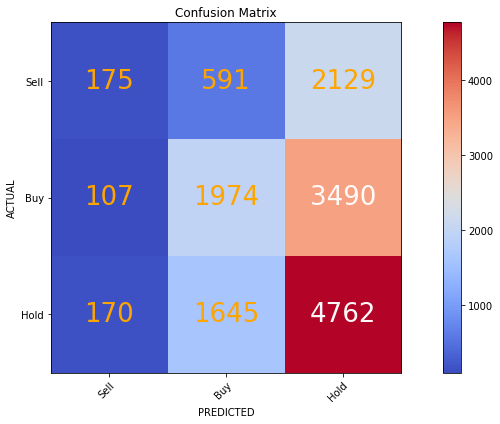

In [17]:
plot_confusion_matrix(y_test, s_pred, title="Confusion Matrix")
np.set_printoptions(precision=1)
# Plot non-normalized confusion matrix
plt.show()

## Saving the Final Model

In [18]:
from joblib import dump

dump(clf, "xgboost.joblib")

['xgboost.joblib']